<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

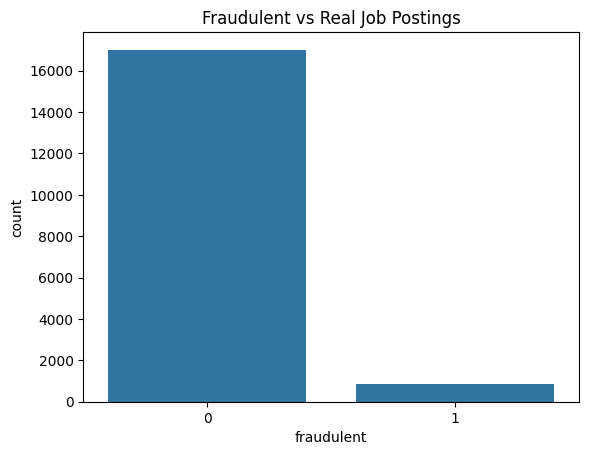

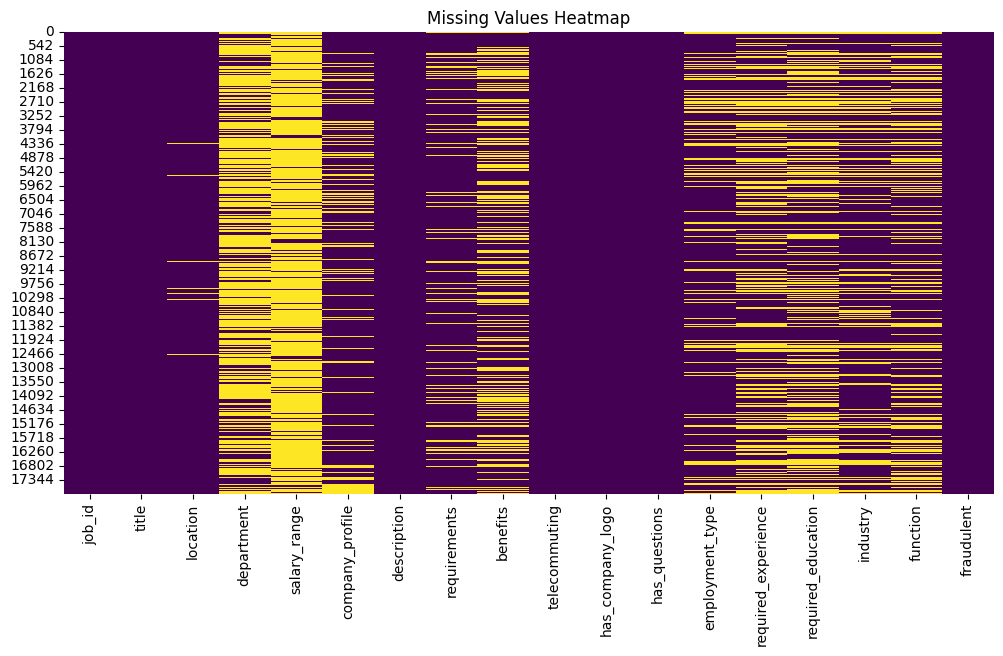


Top 10 titles:
title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64

Top 10 locations:
location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
Name: count, dtype: int64

Top 10 industrys:
industry


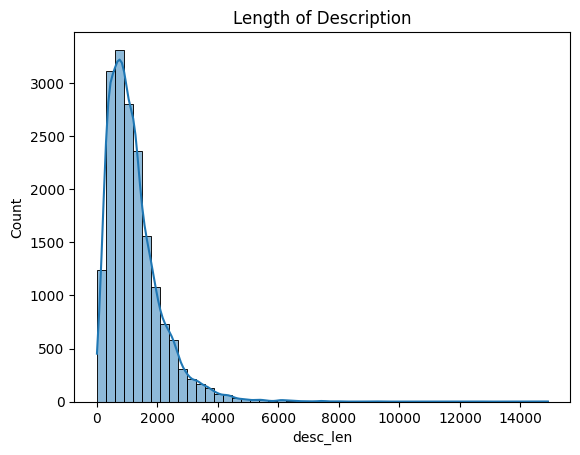

In [10]:
# A. LOAD AND EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/shehryar/Business Analytics/Masters modules /SMM284/fake_job_postings.csv")

# Basic Info
print(df.info())
print(df["fraudulent"].value_counts(normalize=True))

# Visual: Class Distribution
sns.countplot(data=df, x="fraudulent")
plt.title("Fraudulent vs Real Job Postings")
plt.show()

# Missing Values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Most common job titles / locations / industries
for col in ["title", "location", "industry"]:
    print(f"\nTop 10 {col}s:")
    print(df[col].value_counts().head(10))

# Length of description/requirements
df["desc_len"] = df["description"].fillna("").apply(len)
df["req_len"] = df["requirements"].fillna("").apply(len)

sns.histplot(df["desc_len"], bins=50, kde=True)
plt.title("Length of Description")
plt.show()


In [11]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:32:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[3400    3]
 [  66  107]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.97      0.62      0.76       173

    accuracy                           0.98      3576
   macro avg       0.98      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576


=== Random Forest ===
              precision    recall  f1-score   support

    Real (0)       0.98      1.00      0.99      3403
    Fake (1)       0.97      0.62      0.76       173

    accuracy                           0.98      3576
   macro avg       0.98      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576



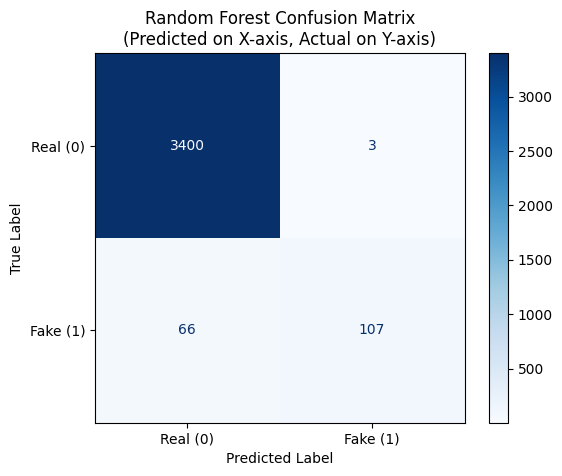


=== XGBoost ===
              precision    recall  f1-score   support

    Real (0)       0.99      0.99      0.99      3403
    Fake (1)       0.74      0.76      0.75       173

    accuracy                           0.98      3576
   macro avg       0.86      0.87      0.87      3576
weighted avg       0.98      0.98      0.98      3576



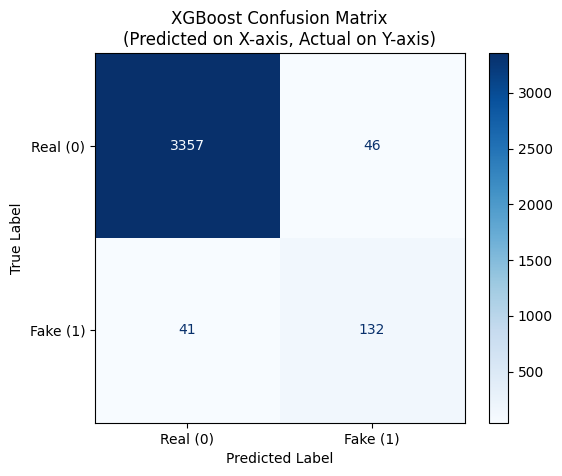


=== Logistic Regression ===
              precision    recall  f1-score   support

    Real (0)       0.99      0.98      0.99      3403
    Fake (1)       0.69      0.77      0.73       173

    accuracy                           0.97      3576
   macro avg       0.84      0.88      0.86      3576
weighted avg       0.97      0.97      0.97      3576



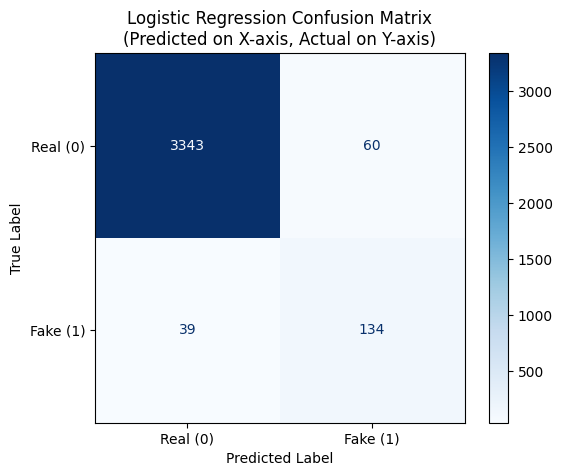

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Drop rows with missing target
df = df.dropna(subset=["fraudulent"])
df.fillna("", inplace=True)

# SELECT FEATURES
X = df[["title", "location", "industry", "description", "requirements"]]
y = df["fraudulent"]

# SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# COLUMNS
categorical = ["title", "location", "industry"]
textual = ["description", "requirements"]

# PIPELINES
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", max_categories=20))
])

text_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=3000))
])

# 1. Combine text columns
X_train["text_combined"] = X_train["description"] + " " + X_train["requirements"]
X_test["text_combined"] = X_test["description"] + " " + X_test["requirements"]

# 2. Define ColumnTransformer
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, ["title", "location", "industry"]),
    ("txt", text_pipe, "text_combined")
])

# 3. Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 4. Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_processed, y_train)

# 5. Train ensemble model (Random Forest or XGBoost)
clf = RandomForestClassifier(n_estimators=200, class_weight=None, random_state=42)
clf.fit(X_resampled, y_resampled)

# XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_resampled, y_resampled)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)

# 6. Predict and evaluate
y_pred = clf.predict(X_test_processed)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

models = {
    "Random Forest": clf,
    "XGBoost": xgb,
    "Logistic Regression": lr
}

for name, model in models.items():
    y_pred = model.predict(X_test_processed)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=["Real (0)", "Fake (1)"]))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "Fake (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix\n(Predicted on X-axis, Actual on Y-axis)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [13]:
X_test.describe()

,title,location,industry,description,requirements,text_combined
count,3576,3576,3576,3576,3576,3576
unique,2777,1177,117,3278,2646,3316
top,English Teacher Abroad,"GB, LND, London",,"Play with kids, get paid for it Love travel? J...",,"Play with kids, get paid for it Love travel? J..."
freq,49,139,977,71,564,71


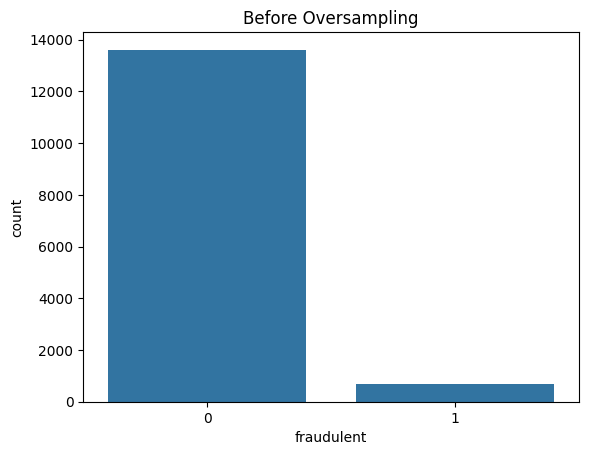

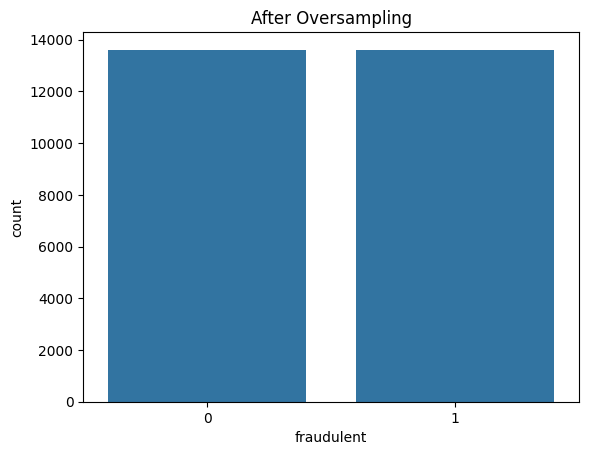

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)
plt.title("Before Oversampling")
plt.show()

sns.countplot(x=y_resampled)
plt.title("After Oversampling")
plt.show()


/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_54754/1082530857.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="importance", y="feature", palette="viridis")


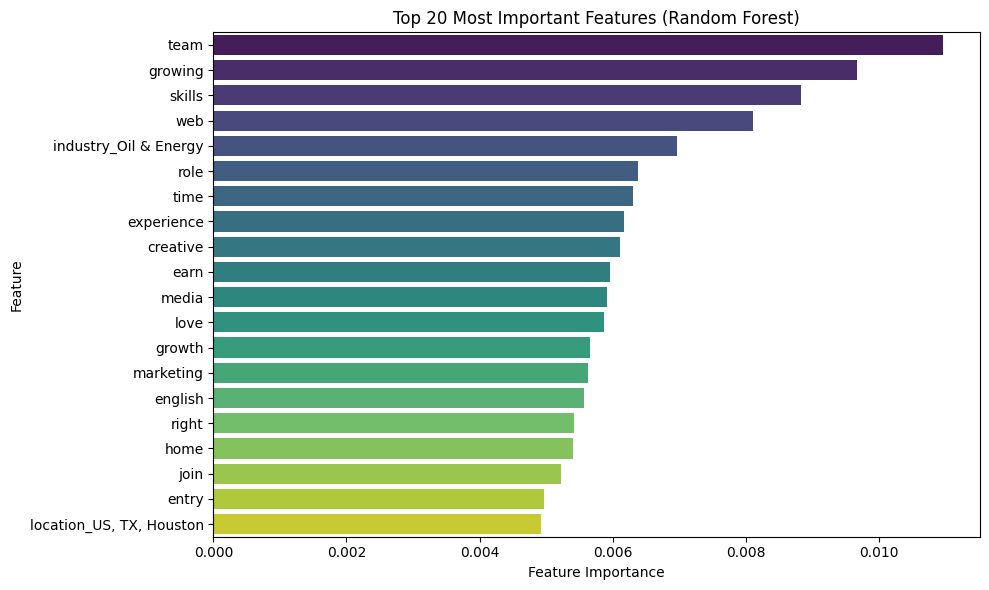

In [15]:
# 1. Get feature names from preprocessor (not clf)
ohe = preprocessor.transformers_[0][1].named_steps['ohe']
tfidf = preprocessor.transformers_[1][1].named_steps['tfidf']

# Get encoded feature names
ohe_features = ohe.get_feature_names_out(["title", "location", "industry"])
tfidf_features = tfidf.get_feature_names_out()

# 2. Combine all feature names
feature_names = np.concatenate([ohe_features, tfidf_features])

# 3. Get feature importances from Random Forest
importances = clf.feature_importances_

# 4. Create DataFrame
import pandas as pd
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)

# 5. Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=feat_df, x="importance", y="feature", palette="viridis")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_54754/3255121567.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="coefficient", y="feature", palette="coolwarm")


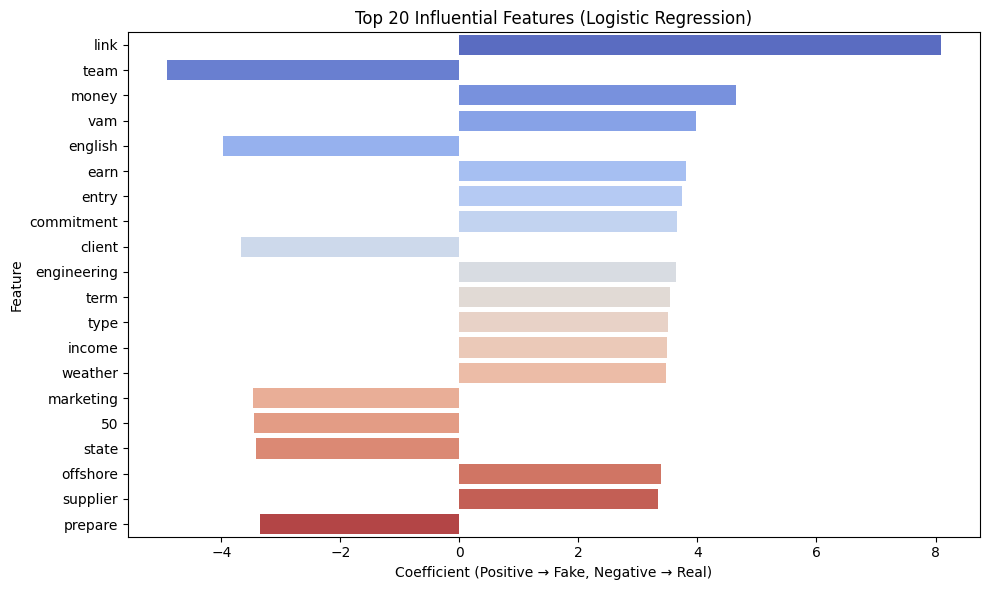

In [17]:
# 1. Get feature names from preprocessor
ohe = preprocessor.transformers_[0][1].named_steps['ohe']
tfidf = preprocessor.transformers_[1][1].named_steps['tfidf']

ohe_features = ohe.get_feature_names_out(["title", "location", "industry"])
tfidf_features = tfidf.get_feature_names_out()

feature_names = np.concatenate([ohe_features, tfidf_features])

# 2. Get coefficients from Logistic Regression
coefs = lr.coef_.flatten()

# 3. Create DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False).head(20)

# 4. Plot
plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x="coefficient", y="feature", palette="coolwarm")
plt.title("Top 20 Influential Features (Logistic Regression)")
plt.xlabel("Coefficient (Positive → Fake, Negative → Real)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Now, I would like to implement Naive Bayes as a potnetial model

In [24]:
# === Naive Bayes Classifier ===
from sklearn.naive_bayes import MultinomialNB

# Train on oversampled data (same as other models)
nb = MultinomialNB()
nb.fit(X_resampled, y_resampled)

# Add to model dictionary for consistent evaluation
models["Naive Bayes"] = nb


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3403
           1       0.24      0.84      0.38       173

    accuracy                           0.87      3576
   macro avg       0.62      0.85      0.65      3576
weighted avg       0.95      0.87      0.90      3576

[[2955  448]
 [  28  145]]


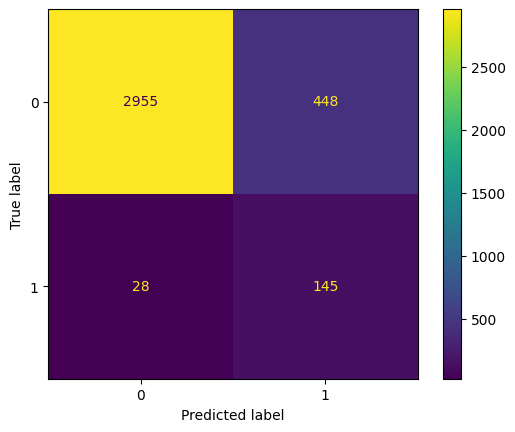

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set using Naive Bayes
y_pred_nb = nb.predict(X_test_processed)

# Print classification metrics
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)

### A few plots to visualise the metris


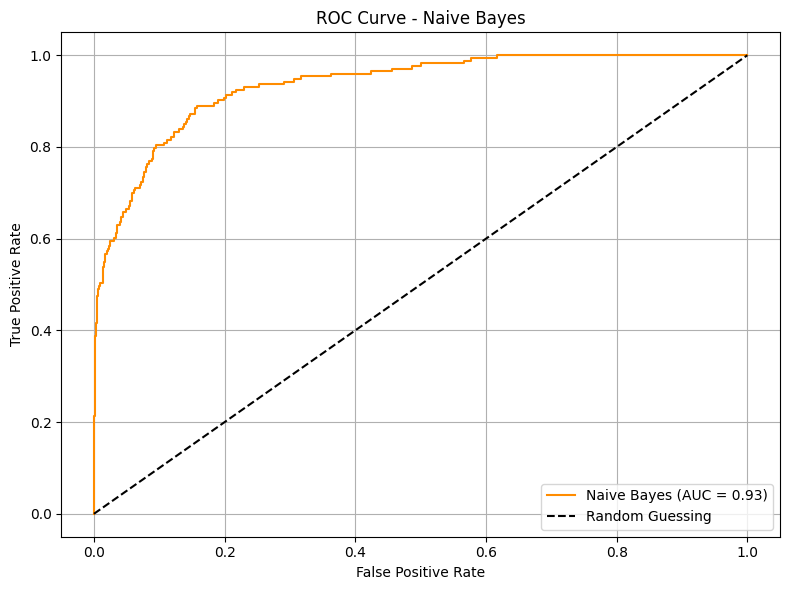

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the fraudulent class (class 1)
y_proba_nb = nb.predict_proba(X_test_processed)[:, 1]

# Compute False Positive Rate, True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_proba_nb)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_proba_nb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

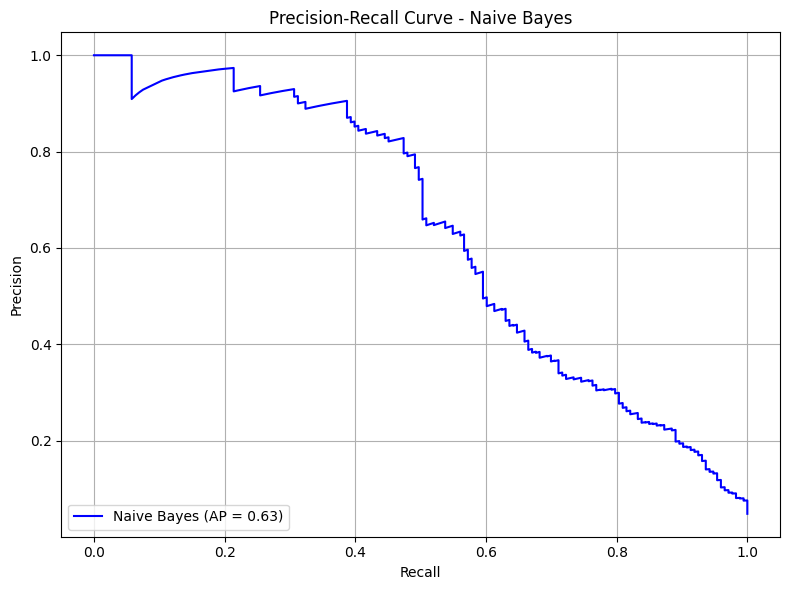

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba_nb)
avg_precision = average_precision_score(y_test, y_proba_nb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Naive Bayes (AP = {avg_precision:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

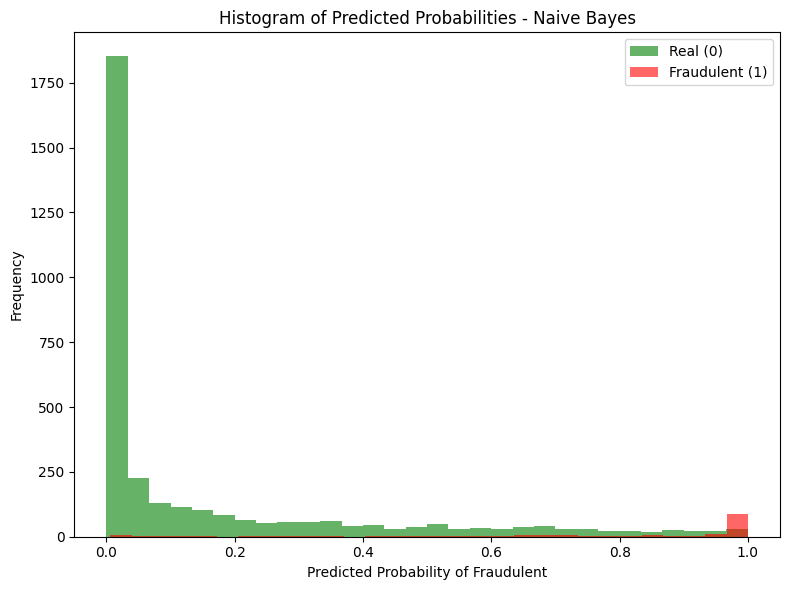

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(y_proba_nb[y_test == 0], bins=30, alpha=0.6, label='Real (0)', color='green')
plt.hist(y_proba_nb[y_test == 1], bins=30, alpha=0.6, label='Fraudulent (1)', color='red')
plt.title('Histogram of Predicted Probabilities - Naive Bayes')
plt.xlabel('Predicted Probability of Fraudulent')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### Naive Bayes Feature Importance Analysis

In [28]:
# 1. Get feature names from both categorical and text pipelines
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
text_names = preprocessor.named_transformers_['txt'].named_steps['tfidf'].get_feature_names_out()

# 2. Combine into full feature name list
all_features = list(cat_names) + list(text_names)

# 3. Get log probabilities from trained Naive Bayes model
log_probs = nb.feature_log_prob_  # shape: [2, n_features]

# 4. Create DataFrame with full feature importance info
import pandas as pd

feature_df = pd.DataFrame({
    'feature': all_features,
    'log_prob_real': log_probs[0],
    'log_prob_fraudulent': log_probs[1],
})
feature_df['log_diff'] = feature_df['log_prob_fraudulent'] - feature_df['log_prob_real']

# 5. Sort and view
top_fraud_indicators = feature_df.sort_values(by='log_diff', ascending=False).head(20)
top_real_indicators = feature_df.sort_values(by='log_diff', ascending=True).head(20)

print("🔍 Top features indicating fraudulent job postings:")
print(top_fraud_indicators)

print("\n🔍 Top features indicating real job postings:")
print(top_real_indicators)

🔍 Top features indicating fraudulent job postings:
                             feature  log_prob_real  log_prob_fraudulent  \
203                             aker     -11.946892            -6.913214   
2696                          subsea     -11.946892            -6.984618   
2032                       petroleum     -10.361238            -7.403151   
2857                          typing      -9.126334            -6.265094   
1890                        offshore      -9.869808            -7.117494   
2266                         ranging      -9.611449            -7.027452   
66                              1000      -9.842769            -7.269072   
537                         clerical      -9.613322            -7.049436   
1241                             gas      -8.931631            -6.367892   
1891                             oil      -8.949207            -6.412411   
54             industry_Oil & Energy      -6.956460            -4.421766   
41               industry_Accounting 

/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_54754/1216150733.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20, y='feature', x='log_diff', palette='coolwarm')


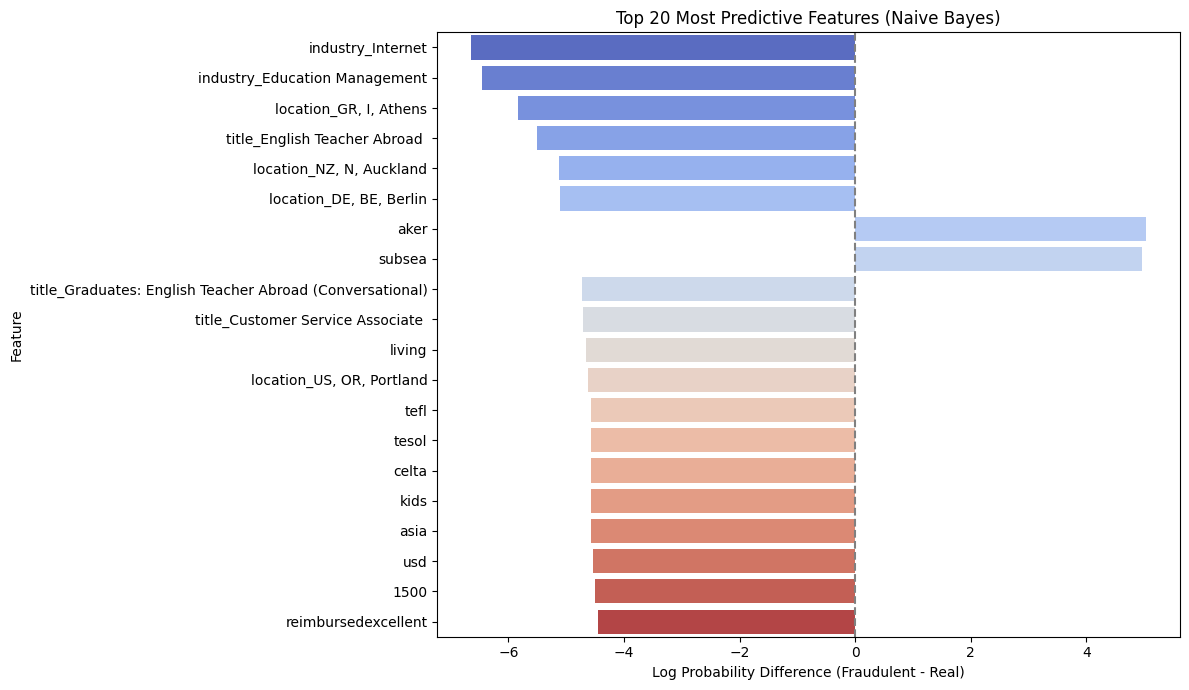

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take absolute value of log_diff for ranking, but keep original values for direction
top_features = feature_df.copy()
top_features['abs_diff'] = top_features['log_diff'].abs()

# Get top 20 features by absolute importance
top_20 = top_features.sort_values(by='abs_diff', ascending=False).head(20)

# Set plot style
plt.figure(figsize=(12, 7))
sns.barplot(data=top_20, y='feature', x='log_diff', palette='coolwarm')

# Plot formatting
plt.title("Top 20 Most Predictive Features (Naive Bayes)")
plt.xlabel("Log Probability Difference (Fraudulent - Real)")
plt.ylabel("Feature")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### Lets amke a calibration curve

#### calibration curve shows how well a model’s predicted probabilities are matching the true likelihoods of an event actually happening.

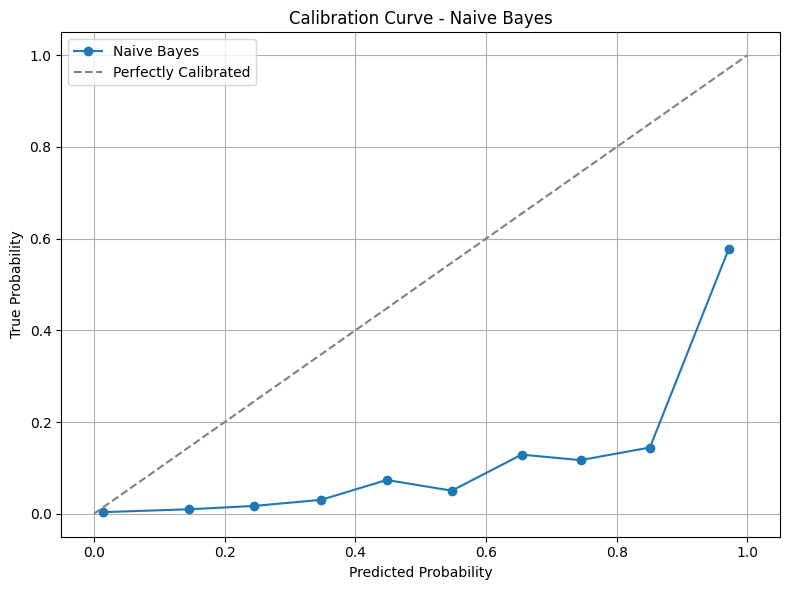

In [34]:
from sklearn.calibration import calibration_curve

# Bin predictions and calculate calibration
prob_true, prob_pred = calibration_curve(y_test, y_proba_nb, n_bins=10)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Naive Bayes')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title("Calibration Curve - Naive Bayes")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
